# Gradient Computation and Update

This function have the following cost:
* adds: $N (N-1) (1+2d) + 2 N d$
* mults: $N (N-1) (2+d) + 2 N d$
* total: $3N (N-1)(1+d) + 4 N d$

So:
$$W =3 N (N-1) (1 + d) + 4Nd \quad flops$$

The memory traffic is:
$$Q = 4(2 N^2 + 2 N d)$$

And so the operational intensity is for low dimensions ($d=2$):
$$I = \frac{9 N (N-1) + 8N}{8 N^2 + 16 N} \approxeq \frac{9}{8} ~ \text{flops/byte}$$
The computation will be **compute bound**.

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from visualization import plot

mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

In [3]:
# Define fixed variables of the problem
d = 2

Lets define the flops depending on the input size.

In [4]:
def get_flops(N):
    W = 3 * N * (N - 1)*(1 + d)
    return W

Cache sizes and limits taking into account that the working set is:
$$W_{set} = 2 N^2 + 2 N d$$

In [5]:
cache_1 = 32 * 2**10    # 32 KB
cache_2 = 256 * 2**10   # 256 KB
cache_3 = 8 * 2**20.    # 8 MB


N_cache1 = np.sqrt(cache_1 / 4 / 2 + 1) - 1
N_cache2 = np.sqrt(cache_2 / 4 / 2 + 1) - 1
N_cache3 = np.sqrt(cache_3 / 4 / 2 + 1) - 1
print(f"Cache 1 limit size: {N_cache1:.0f}")
print(f"Cache 2 limit size: {N_cache2:.0f}")
print(f"Cache 3 limit size: {N_cache3:.0f}")

Cache 1 limit size: 63
Cache 2 limit size: 180
Cache 3 limit size: 1023


## System Information

CPU: Intel Core i7-6820HQ @ 2.70GHz

Cache:
* L1 Cache: 32 KB
* L2 Cache: 256 KB
* L3 Cache: 8 MB

Compiler:
`g++-4.9 (Homebrew GCC 4.9.4) 4.9.4`

## Benchmark 1

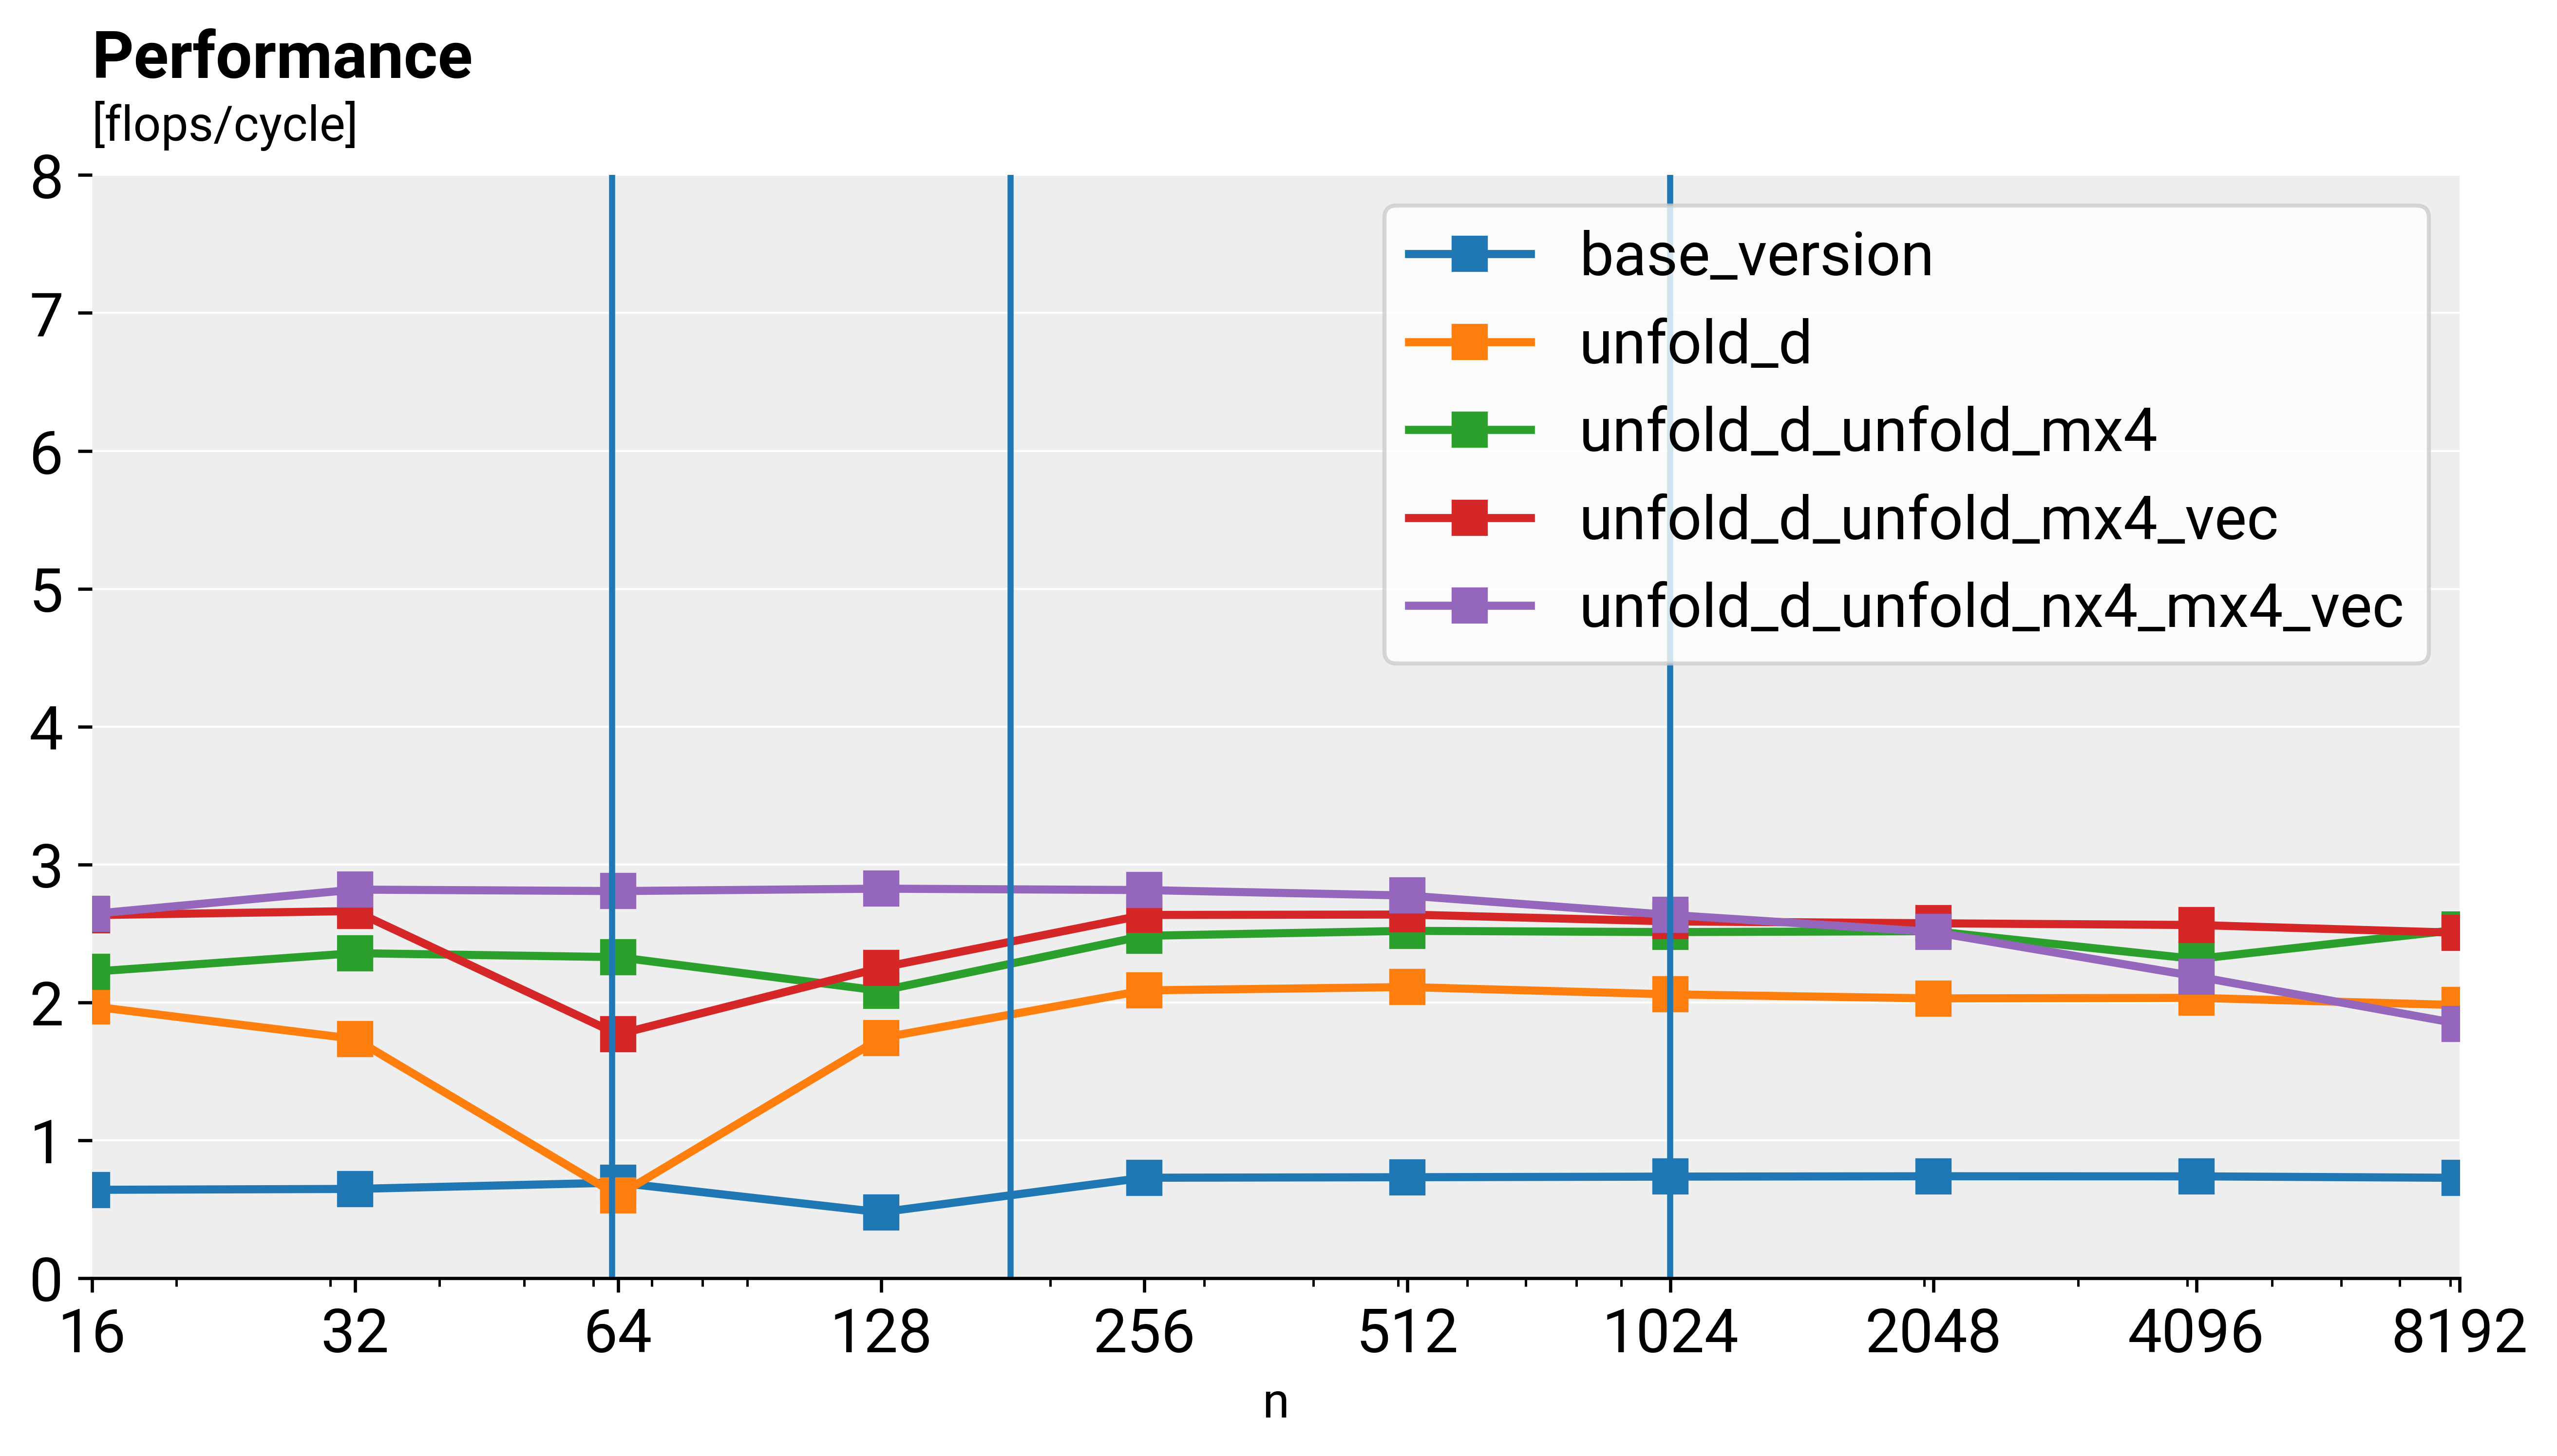

In [15]:
data = pd.read_csv("./bench1.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = {
    "base_version": 3 * N * (N - 1)*(1 + d) + 4*N*d,
    "unfold_d": 3 * N * (N - 1)*(1 + d) + 4*N*d,
    "unfold_d_unfold_mx4": 3 * N * (N - 1)*(1 + d)+4*N*d,
    "unfold_d_unfold_mx4_vec": N/4*N/4*(4*8*6) + N*d/(8*4) *(4*8+4*16+4*8),
    "unfold_d_unfold_nx4_mx4_vec": N/16*(N/4*(64*8 + 4*7*8 + 4*8) + (4*8 + 4*16)) + N/(4*8) * (8*8),
}

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops[func] / cycles
    perf.append(P)
perf = np.array(perf)

ax = plot(N, perf, labels=func_names, ylim=8, title="Performance")
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()